In [1]:
from sympy import symbols, solve, exp, lambdify
from sympy.plotting.plot import plot
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

%run config.ipynb

import json
with open("config.json") as f:
    CONFIG = json.load(f)
    params = CONFIG["clasp"] + CONFIG["microtubules"] + CONFIG["growth"]

## Steady State Solutions

In [2]:
def setup(params):

    # Define parameters and variables
    c_max, p, q, u, v, k_on, k_off, k_in, t_2, a_tau, b_tau, o_max, a_O, b_O, g_min, g_B, g_tau = params
    
    # Define the initial cell length and symbols
    L = 10
    C, R0, RB, T, O, B = symbols('C R0 RB T O B')
            
    # Solve the system at steady state
    system = [
        c_max - p*(1 + q*RB)*C,
        u*(1 + v*C) - k_on*R0*B - k_in*R0 + k_off*RB,
        k_on*R0*B - k_in*RB - k_off*RB,
        a_tau*C - b_tau*T
    ]

    # Choose the second root to ensure positive solutions
    ss = solve(system, [C, R0, RB, T], dict = True)[-1]
    return [lambdify(B, ss[h]) for h in [C, R0, RB, T]]

<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in divide
  return 0.0128205128205128*(-81.0*B + 83.8391316748927*sqrt(B**2 + 0.361929150661545*B + 0.00910513586569925) - 8.0)/B
<lambdifygenerated-2>:2: RuntimeWarning: invalid value encountered in divide
  return 0.333333333333333*(75.0*B + 83.8391316748927*sqrt(B**2 + 0.361929150661545*B + 0.00910513586569925) - 8.0)/(B*(3.0*B + 8.0))
<lambdifygenerated-4>:2: RuntimeWarning: divide by zero encountered in divide
  return -0.0128205128205128*(81.0*B + 8.0)/B + 1.07486066249862*sqrt(B**2 + 0.361929150661545*B + 0.00910513586569925)/B
<lambdifygenerated-4>:2: RuntimeWarning: invalid value encountered in add
  return -0.0128205128205128*(81.0*B + 8.0)/B + 1.07486066249862*sqrt(B**2 + 0.361929150661545*B + 0.00910513586569925)/B


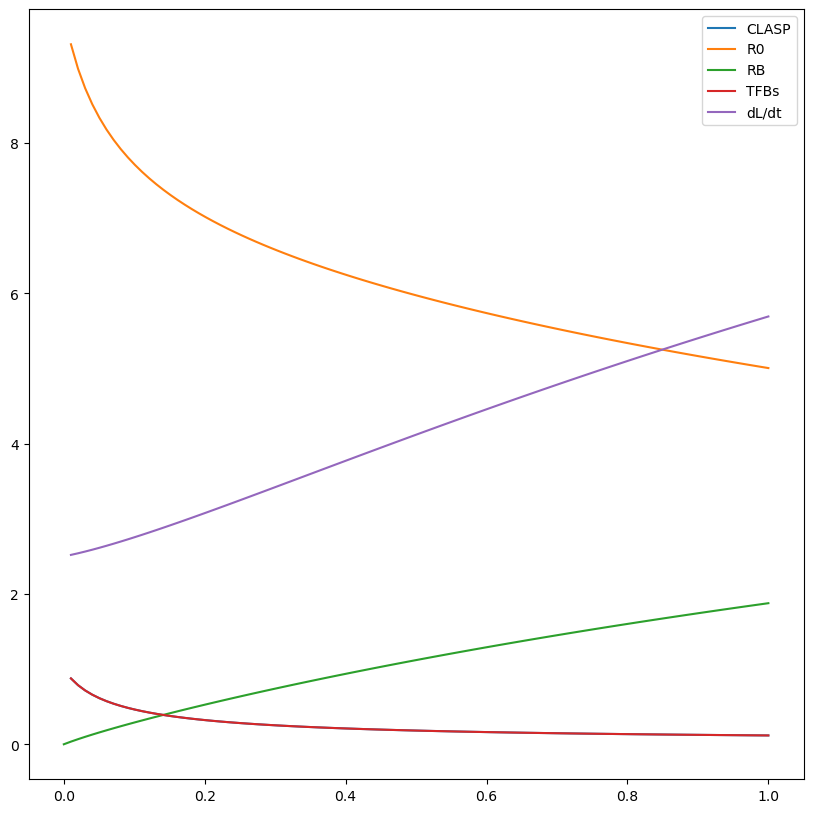

In [3]:
funcs = setup(params)

# Plot BR against the steady state solutions
fig, ax = plt.subplots(figsize = (10, 10))
xs = np.linspace(0, 1, 100)

# Plot the hormones and proteins
labels = ["CLASP", "R0", "RB", "TFBs", "OTAs"]
for f, l in zip(funcs, labels):
    ax.plot(xs, f(xs), label = l)

# Plot the growth rate
rb = funcs[2]
t = funcs[3]
ax.plot(xs, g_min + (g_B * rb(xs)) / (1 + g_tau * t(xs)), label = "dL/dt")
ax.legend()

## Single Cell Model

In [4]:
# Takes a time and computes the cell's position in um above the QC
def get_position(t):

    # Division zone
    if t < 18:
        position = (200 / 18) * t
        
    # Transition zone
    elif t < 28:
        position = 200 + (300 / 10) * (t - 18)

    # Elongation zone
    elif t <= 32:
        position = 500 + (400 / 4) * (t - 28)

    return position

def get_brassinosteroid(t):
    p = get_position(t)
    return 0.25 + 0.75 * ((p ** 6) / (300 ** 6 + p ** 6))

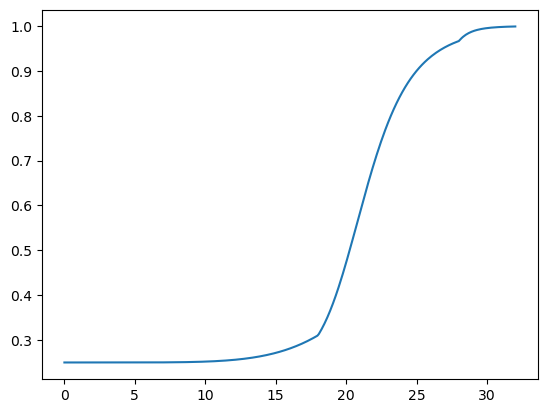

In [5]:
xs = np.linspace(0, 32, 320)
ps = np.vectorize(get_position)(xs)
bs = np.vectorize(get_brassinosteroid)(xs)
plt.plot(xs, bs)

In [6]:
def get_growth(H, params):
    C, R0, RB, T = H
    c_max, p, q, u, v, k_on, k_off, k_in, t_2, a_tau, b_tau, o_max, a_O, b_O, g_min, g_B, g_tau = params
    return g_min + (g_B * RB) / (1 + g_tau * T)

def check_error(L, t):
    
    t = round(t, 2)
    if t == 18:
        return (L - 10) ** 2
    if t == 28:
        return (L - 30) ** 2
    if t == 32:
        return (L - 130) ** 2
    return 0
    

def simulate_cell(L, params, start, dt):

    ts = np.arange(start, 32.1, dt)
    error, frames, sizes = 0, [], []
    funcs = setup(params)
    
    for t in ts:
        B = get_brassinosteroid(t)
        H = [f(B) for f in funcs]
        L += get_growth(H, params) * dt
        error += check_error(L, t)
        frames.append(H)
        sizes.append(L)

    return ts, frames, sizes, error

def plot_frames(ts, frames):

    fig, ax = plt.subplots()
    frames = np.array(frames).T
    labels = ["CLASP", "R0", "RB"]
    for ys, l in zip(frames, labels):
        ax.plot(ts, ys, label = l)
    
    ax.set_ylim(0, 10)
    ax.set_xlabel("Time Since Lineage Creation")
    ax.set_ylabel("Hormone Level")
    ax.legend()
    
def plot_sizes(ts, sizes):

    fig, ax = plt.subplots()
    ax.vlines(18, 0, 150, colors = "b", linestyles = "dashed", label = "DZ/TZ")
    ax.vlines(28, 0, 150, colors = "g", linestyles = "dashed", label = "TZ/EZ")
    ax.vlines(32, 0, 150, colors = "r", linestyles = "dashed", label = "End of EZ")
    ax.plot(18, 10, 'ko')
    ax.plot(28, 30, 'ko')
    ax.plot(32, 130, 'ko')
    ax.set_xlabel("Time Since Lineage Creation")
    ax.set_ylabel("Cell Height (Microns)")
    ax.plot(ts, sizes, "m")
    ax.legend()


3274.8523391398658


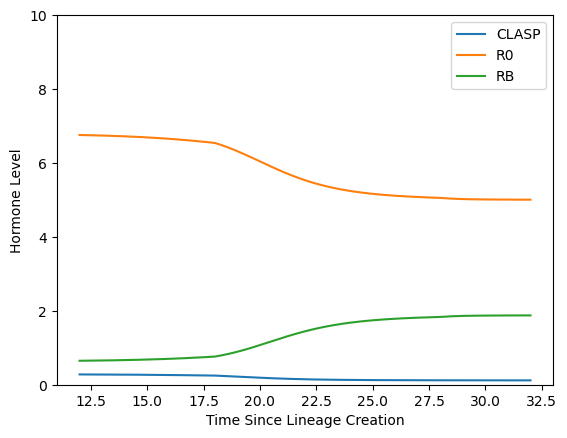

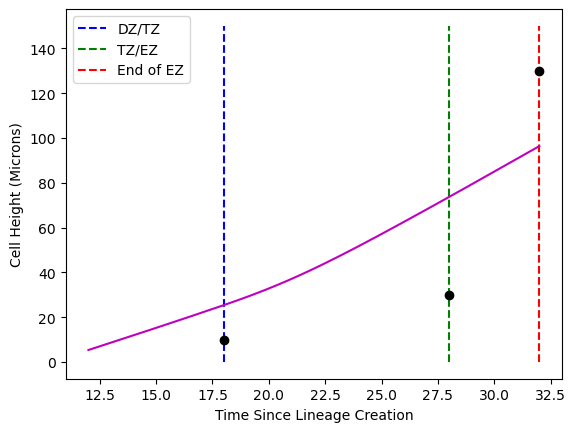

In [7]:
ts, frames, sizes, error = simulate_cell(5, params, 12, 0.1)
plot_frames(ts, frames)
plot_sizes(ts, sizes)
print(error)

## Parameter Search

In [8]:
def get_parameter_lists(params):
    
    params_list = []
    
    for i, p in enumerate(params):
        
        if params[i] > 0.2:
            pi_low = params.copy()
            pi_low[i] = round(pi_low[i] - 0.2, 1)
            params_list.append(pi_low)
            
        pi_high = params.copy()
        pi_high[i] = round(pi_high[i] + 0.2, 1)
        params_list.append(pi_high)
        
    return params_list     


def optimize_parameters(L, initial_params, start, dt):

    current_params = initial_params
    ts, frames, sizes, current_error = simulate_cell(L, initial_params, start, dt)

    while True:
        
        # Generate a list of lists of new parameters to search through
        params_list = get_parameter_lists(current_params)
    
        # Check the error on each of these lists of parameters and find the lowest one
        tests = []
        for p in params_list:
            ts, frames, sizes, error = simulate_cell(L, p, start, dt)
            tests.append((error, p))

        # Find the smallest error in the tests:
        best_error, best_params = sorted(tests, key = lambda t : t[0])[0]

        # Repeat the process until the current parameters are optimal
        if best_error == current_error:
            break

        print("BEST ERROR: ", best_error)
        print("BEST PARAMS: ", best_params)
        current_params = best_params
        current_error = best_error
        
    return current_params

In [9]:
optimize_parameters(5, params, 12, 0.1)

BEST ERROR:  3254.788824124088
BEST PARAMS:  [1, 1, 4, 6.5, 0.5, 1.5, 3, 1, 0, 1, 1, 1, 1, 1, 2.3, 2.5, 4]
BEST ERROR:  3218.6287264126463
BEST PARAMS:  [1, 1, 4, 6.5, 0.5, 1.5, 3, 1, 0, 1, 1, 1, 1, 1, 2.3, 2.7, 4]
BEST ERROR:  3212.5315541956024
BEST PARAMS:  [1, 1, 4, 6.5, 0.5, 1.5, 3, 1, 0, 1, 1, 1, 1, 1, 2.1, 2.7, 4]
BEST ERROR:  3166.5900322249145
BEST PARAMS:  [1, 1, 4, 6.5, 0.5, 1.5, 3, 1, 0, 1, 1, 1, 1, 1, 2.1, 2.9, 4]
BEST ERROR:  3152.93514319625
BEST PARAMS:  [1, 1, 4, 6.5, 0.5, 1.5, 3, 1, 0, 1, 1, 1, 1, 1, 2.1, 3.1, 4]
BEST ERROR:  3118.736256576682
BEST PARAMS:  [1, 1, 4, 6.5, 0.5, 1.5, 3, 1, 0, 1, 1, 1, 1, 1, 1.9, 3.1, 4]
BEST ERROR:  3095.2999432887696
BEST PARAMS:  [1, 1, 4, 6.5, 0.5, 1.5, 3, 1, 0, 1, 1, 1, 1, 1, 1.9, 3.3, 4]
BEST ERROR:  3075.0673994679396
BEST PARAMS:  [1, 1, 4, 6.5, 0.5, 1.5, 3, 1, 0, 1, 1, 1, 1, 1, 1.7, 3.3, 4]
BEST ERROR:  3041.84966192079
BEST PARAMS:  [1, 1, 4, 6.5, 0.5, 1.5, 3, 1, 0, 1, 1, 1, 1, 1, 1.7, 3.5, 4]
BEST ERROR:  3035.5834608986947
BE

[1, 1, 4, 6.5, 0.1, 1.5, 3, 1, 0, 1, 1, 1, 1, 1, 0.1, 6.1, 4]